# Plug-and-Play Image Restoration

<a target="_blank" href="https://colab.research.google.com/github/generativemodelingmva/generativemodelingmva.github.io/blob/main/tp2324/tp8_pnp.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<br/><br/><br/>

This practical session is dedicated to the implementation of plug-and-play algorithms with pre-learned denoisers.

In [ ]:
import numpy as np
import torch
from torch.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt
import time

import torch
print(torch.__version__)
pi = torch.pi
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

!pip install bm3d
# !pip install deepinv
# or last version of deepinv:
!pip install git+https://github.com/deepinv/deepinv.git#egg=deepinv
import deepinv as dinv

# Uncomment these two lines to download the files for this session
!wget https://perso.telecom-paristech.fr/aleclaire/mva/tp8.zip
!unzip tp8.zip

2.2.1+cu121
cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.4 MB/s eta 0:00:00
  Cloning https://github.com/deepinv/deepinv.git to /tmp/pip-install-f61zvn3y/deepinv_eafd527e189f43df98ca80675995d815
  Running command git clone --filter=blob:none --quiet https://github.com/deepinv/deepinv.git /tmp/pip-install-f61zvn3y/deepinv_eafd527e189f43df98ca80675995d815
  Resolved https://github.com/deepinv/deepinv.git to commit 1220297ac4a8a6d7aadfbc9239bf0e0b49aebd2a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
def rgb2gray(u):
    return 0.2989 * u[:,:,0] + 0.5870 * u[:,:,1] + 0.1140 * u[:,:,2]

def str2(chars):
    return "{:.2f}".format(chars)

def psnr(uref,ut,M=1):
    rmse = np.sqrt(np.mean((np.array(uref.cpu())-np.array(ut.cpu()))**2))
    return 20*np.log10(M/rmse)

def tensor2im(x):
    return x.detach().cpu().permute(2,3,1,0).squeeze().clip(0,1)

# viewimage
import tempfile
import IPython
from skimage.transform import rescale

def viewimage(im, normalize=True,vmin=0,vmax=1,z=2,order=0,titre='',displayfilename=False):
    # By default, values are scaled with black=0 and white=1
    # In order to adapt the dynamics to the image, enter vmin and vmax as None
    im = im.detach().cpu().permute(2,3,1,0).squeeze()
    imin= np.array(im).astype(np.float32)
    channel_axis = 2 if len(im.shape)>2 else None
    imin = rescale(imin, z, order=order, channel_axis=channel_axis)
    if normalize:
        if vmin is None:
            vmin = imin.min()
        if vmax is None:
            vmax = imin.max()
        imin-=vmin
        if np.abs(vmax-vmin)>1e-10:
            imin = (imin.clip(vmin,vmax)-vmin)/(vmax-vmin)
        else:
            imin = vmin
    else:
        imin=imin.clip(0,255)/255
    imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    if displayfilename:
        print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))


# alternative viewimage if the other one does not work:
def Viewimage(im,dpi=100,cmap='gray'):
    plt.figure(dpi=dpi)
    if cmap is None:
        plt.imshow(np.array(im))
    else:
        plt.imshow(np.array(im),cmap=cmap)
    plt.axis('off')
    plt.show()

<br/><br/><br/>

# Exercise 1: Plug-and-Play Image Deblurring (with periodic convolution)

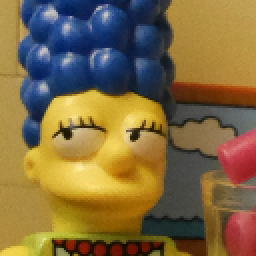

In [ ]:
# Open the image
x0 = torch.tensor(plt.imread('im/simpson512crop.png'),device=device)
# x0 = torch.tensor(plt.imread('im/parrots.png'),device=device); x0 = x0[100:356,370:626,:]
# x0 = torch.tensor(plt.imread('im/marge2.png'),device=device)
# x0 = torch.tensor(plt.imread('im/simpson512.png'),device=device)
M,N,C = x0.shape
# Permute dimensions to fit tensor convention
x0 = x0.permute(2,0,1).unsqueeze(0)

viewimage(x0)

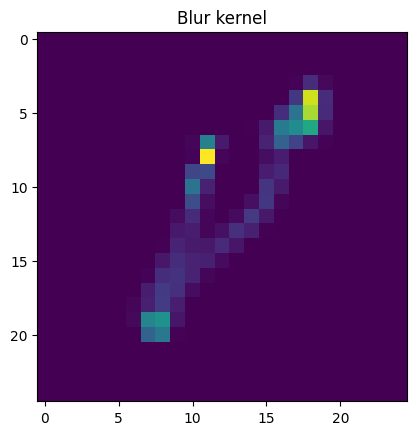

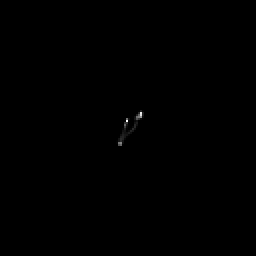

In [ ]:
# Load a blur kernel
kt = torch.tensor(np.loadtxt('kernels/kernel8.txt'))
# kt = np.loadtxt('kernels/levin7.txt')
(m,n) = kt.shape

plt.imshow(kt)
plt.title('Blur kernel')
plt.show()

# Embed the kernel in a MxNx3 image, and put center at pixel (0,0)
k = torch.zeros((M,N),device=device)
k[0:m,0:n] = kt/torch.sum(kt)
k = torch.roll(k,(-int(m/2),-int(n/2)),(0,1))
#k = k[:,:,None].repeat(1,1,3)
#k = k.permute(2,0,1).unsqueeze(0)
k = k[None,None,:,:]
fk = fft2(k)

viewimage(fftshift(k),vmin=None,vmax=None)


## Test a pre-learned denoiser

Compute a noisy image
$$ y = x_0 + \xi $$
where $\xi \sim \mathcal{N}(0,\nu^2 \mathsf{Id})$.
Denoise the image $y$ by using a pre-learned denoiser.

PSNR(x0,y) = 42.17


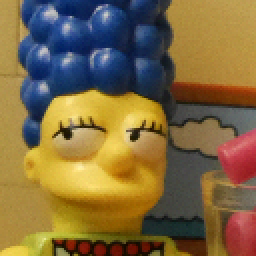

PSNR(x0,Dy) = 45.06


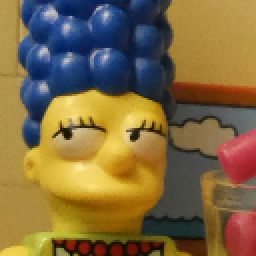

In [ ]:
nu = 2/255 # 0.15
y = x0 + nu*torch.randn_like(x0,device=device)

# Load the DRUNet denoiser
# https://deepinv.github.io/deepinv/stubs/deepinv.models.DRUNet.html
# D = dinv.models.DRUNet(pretrained='ckpts/drunet_color.pth').to(device)

# Load the BM3D denoiser
# https://deepinv.github.io/deepinv/stubs/deepinv.models.BM3D.html
# D = dinv.models.BM3D().to(device)

# Load the DnCNN denoiser (WARNING: the proposed weights are only trained for noise level sigma = 2/255)
# https://deepinv.github.io/deepinv/stubs/deepinv.models.DnCNN.html
D = dinv.models.DnCNN(pretrained='ckpts/dncnn_sigma2_color.pth').to(device)
# D = dinv.models.DnCNN(pretrained='ckpts/dncnn_sigma2_lipschitz_color.pth').to(device)

# D = dinv.models.DiffUNet().to(device)
# D = dinv.models.TVDenoiser()   # in last version of deepinv

# noisy image
print('PSNR(x0,y) = %.2f'%psnr(x0,y))
viewimage(y)
# denoise image
Dy = D(y,sigma=nu)
print('PSNR(x0,Dy) = %.2f'%psnr(x0,Dy))
viewimage(Dy)

## Image deblurring with PnP-PGD

Implement the forward model
$$ y = A(x_0) + \xi $$
where $\xi \sim \mathcal{N}(0,\nu^2 \mathsf{Id})$.
Write functions implementing the operator $A(x)$ and the data-fidelity term $f(x)$.

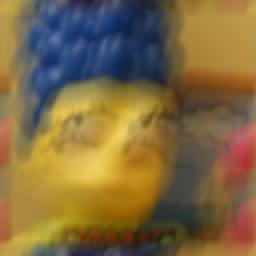

In [ ]:
nu = .01  # noise level
torch.manual_seed(1)  # fix random seed for reproducibility

# Define corresponding operator and data-fidelity
def A(x):
    return ifft2(fk*fft2(x)).real

def f(x):
    return 1/(2*nu**2)*torch.sum((y - A(x))**2)### TODO ###

# Draw a sample of the direct model for image deblurring (apply blur and add Gaussian noise)
### TODO ###
Noise = 0.001*torch.randn(y.shape)
y = A(x0) + Noise
viewimage(y)

In this question, we will perform deblurring with the PnP-PGD algorithm
$$ x_{k+1} = D_\sigma \circ (\operatorname{Id} - \tau \nabla f) (x_k) $$
where $f(x) = \frac{1}{2\nu^2} \|Ax-y\|_2^2$ is the data-fidelity term.

Recall that $\tau$ should be $< \frac{2}{L}$ where $L$ is the Lipschitz constant of $\nabla f$.

Complete the following cell progressively, in order to address the following points:
1. Implement the PnP-PGD algorithm, and display the deblurred image.
2. Track the evolution of the PSNR.
3. Track the evolution of the residual $r_n = \frac{\|x_n - x_{n-1}\|}{\|x_0\|}$.
4. Try to adjust the parameter $\tau$ (gradient step size / strength of data-fidelity).
5. Try to adjust the parameter $s$ (strength of the denoiser).
6. Track the evolution of $v_n = \frac{\|D(x_n) - D(x_{n-1})\|}{\|x_n - x_{n-1}\|}$ (which lower bounds the Lipschitz constant of $D$).
7. Store the PSNR/Residual tables and compare with several denoisers.

We need to calculate the gradient of $f$ to compute the PnP-PGD.
It is immediate to see that $\nabla f = \frac{1}{\nu^2}A^\dagger(Ax - y)$. The question then becomes : how to compute $A^\dagger$, knowing that $Ax = k\star x$, where $\star$ denotes the $\mathbb{Z}^2$ convolution.
After a quick calculation, one sees that $A^\dagger$ is also a convolution, but with a different kernel. Indeed, $A^\dagger y = \tilde{k}\star y$. One has $\tilde{k}[i,j] = k[-i,-j]$. And in fourier domain, it is simply $\widehat{A^\dagger y} = \hat{\tilde{k}}y =\bar{\hat{k}}y$, with $\bar{z}$ denoting the conjugate of $z$.
We will compute the gradient as:
$$
\nabla f(x) = \frac{1}{\nu^2}\mathcal{F}^{-1}(\tilde{k}\mathcal{F}(Ax - y))
$$

In [ ]:
tau = 2*nu**2###
s = 2*nu  # strength of the denoiser

# initialize with blurry image
x = y.clone()

fk_conj = np.conjugate(fk) #take the conjugate of fk
psnrtab = []  # to store psnr
rtab = []     # to store residual
vtab = []     # to store denoiser variations

x0_norm = torch.norm(x0)
niter = 100
t0 = time.time()
print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(0,niter,0,psnr(x0,y)))

for it in range(niter):
    nabla = 1/(nu**2)*ifft2(fk_conj*fft2(A(x) - y)).real
    x_prev = x.clone()
    x = D(x - tau*nabla)
    norm_diff = torch.norm(x - x_prev)

    #rtab
    rtab += [norm_diff/x0_norm]

    #psnrtab
    psnrt = psnr(x,y)
    psnrtab += [psnrt]

    #vtab
    vtab += [torch.norm(D(x) - D(x_prev))/norm_diff]
    if (it+1)%10==0:
        print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(it+1,niter,time.time()-t0,psnrt))
        viewimage(x)

xpgd = x   # save for later comparisons

plt.plot(psnrtab)
plt.title('PSNR')
plt.show()

# plt.semilogy(rtab)
# plt.title('Residual Norm')
# plt.show()

# plt.plot(vtab)
# plt.title('Denoiser Variations')
# plt.show()

In [ ]:
# Save the tables obtained with various denoisers for later comparisons

# psnrtabtmp = psnrtab.copy()
# rtabtmp = rtab.copy()
# vtabtmp = vtab.copy()
# rtab_bm3d = rtab.copy()
# psnrtab_bm3d = psnrtab.copy()
# vtab_bm3d = vtab.copy()
# rtab_drunet = rtab.copy()
# psnrtab_drunet = psnrtab.copy()
# vtab_drunet = vtab.copy()
# rtab_dncnn = rtab.copy()
# psnrtab_dncnn = psnrtab.copy()
# vtab_dncnn = vtab.copy()
# rtab_dncnnlip = rtab.copy()
# psnrtab_dncnnlip = psnrtab.copy()
# vtab_dncnnlip = vtab.copy()

Compare with explicit regularizations (Tychonov, smoothTV).

PSNR(x0,xtych) = 29.71


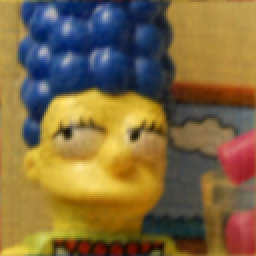

PSNR(x0,xtv) = 33.62


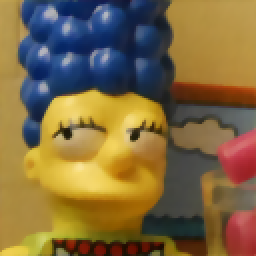

In [ ]:
# Deblurring with Tychonov Regularization
def tych_deblur(y,k,lam=0.01):
    _,_,M,N = y.shape
    xi = torch.arange(M)
    ind = (xi>M/2)
    xi[ind] = xi[ind]-M
    zeta = torch.arange(N)
    ind = (zeta>N/2)
    zeta[ind] = zeta[ind]-N
    Xi,Zeta = torch.meshgrid(xi,zeta,indexing='ij')
    Xi = Xi[None,None,:,:].to(device)
    Zeta = Zeta[None,None,:,:].to(device)
    fh = torch.conj(fk)/(torch.abs(fk)**2 + 8 * lam * (torch.sin(pi*Xi/M)**2 + torch.sin(pi*Zeta/N)**2))
    return ifft2(fft2(y)*fh).real

xtych = tych_deblur(y,k)

# Smooth TV regularization
def stv_deblur(A,y,xinit,niter=1000,lam=0.002,ep=0.01,lr=None):
    if lr is None:
        lr = 1.9/(1+lam*8/ep)
    x = xinit.clone().requires_grad_(True)
    optim = torch.optim.SGD([x], lr=lr)
    losslist = []
    for it in range(niter):
        d1 = torch.roll(x,-1,2) - x
        d2 = torch.roll(x,-1,3) - x
        reg = torch.sum(torch.sqrt(ep**2+d1**2+d2**2))
        loss = torch.sum((A(x)-y)**2) + lam*reg
        losslist.append(loss.item())
        optim.zero_grad()
        loss.backward()
        optim.step()
    return x.detach(),losslist

xtv,losslist = stv_deblur(A,y,y.clone())
# plt.plot(losslist)
# plt.show()

# Display the results
print('PSNR(x0,xtych) = %.2f'%psnr(x0,xtych))
viewimage(xtych)
print('PSNR(x0,xtv) = %.2f'%psnr(x0,xtv))
viewimage(xtv)

Compare results obtained with PnP-PGD and with explicit regularizers.

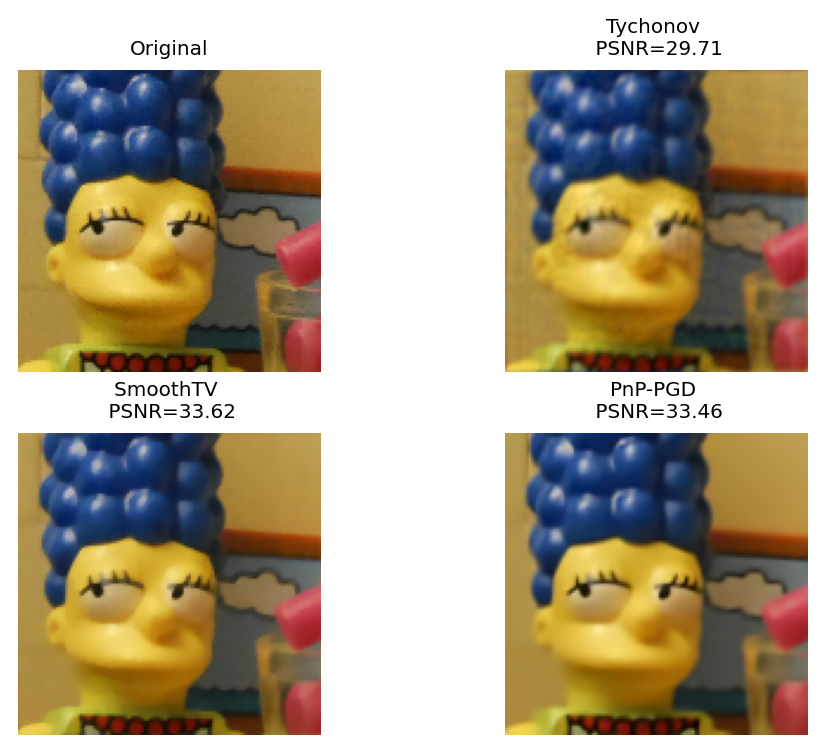

In [ ]:
plt.figure(dpi=180)
plt.subplot(2,2,1)
plt.imshow(tensor2im(x0), cmap='gray')
plt.title('Original',fontsize=8)
# plt.imshow(tensor2im(y), cmap='gray')
# plt.title('Degraded \n PSNR='+str2(psnr(x0,y)),fontsize=8)
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(tensor2im(xtych), cmap='gray')
plt.title('Tychonov \n PSNR='+str2(psnr(x0,xtych)),fontsize=8)
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(tensor2im(xtv), cmap='gray')
plt.title('SmoothTV \n PSNR='+str2(psnr(x0,xtv)),fontsize=8)
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(tensor2im(xpgd), cmap='gray')
plt.title('PnP-PGD \n PSNR='+str2(psnr(x0,xpgd)),fontsize=8)
plt.axis('off')
plt.show()

Compare Residual Norms, PSNR, and Denoiser variations for various denoisers.

In [ ]:
# restab_drunet = restab.copy()
# psnrtab_drunet = psnrtab.copy()
# restab_dncnn = restab.copy()
# psnrtab_dncnn = psnrtab.copy()
# restab_dncnnlip = restab.copy()
# psnrtab_dncnnlip = psnrtab.copy()

plt.figure(dpi=150)
plt.semilogy(restab_dncnn,label='DnCNN')
plt.semilogy(restab_dncnnlip,label='DnCNNLip')
plt.semilogy(restab_drunet,label='DRUNet')
plt.semilogy(restab_bm3d,label='BM3D')
plt.legend()
plt.title('Residual Norm')
plt.show()

plt.figure(dpi=150)
plt.plot(psnrtab_dncnn,label='DnCNN')
plt.plot(psnrtab_dncnnlip,label='DnCNNLip')
plt.plot(psnrtab_drunet,label='DRUNet')
plt.plot(psnrtab_bm3d,label='BM3D')
plt.plot([psnr(x0,xtv)]*niter,label='smoothTV')
plt.plot([psnr(x0,xtych)]*niter,label='Tychonov')
plt.legend()
plt.title('PSNR')
plt.show()

plt.figure(dpi=150)
plt.plot(liptab_dncnn,label='DnCNN')
plt.plot(liptab_dncnnlip,label='DnCNNLip')
plt.plot(liptab_drunet,label='DRUNet')
plt.plot(liptab_bm3d,label='BM3D')
plt.legend()
plt.title('Denoiser Variations')
plt.show()

<br/><br/>

## Image deblurring with PnP-HQS

Implement the proximal operator of the data-fidelity term:
$$\mathsf{Prox}_{\tau f}(x) = \left( \frac{1}{\nu^2} A^T A + \frac{1}{\tau} \mathsf{Id} \right)^{-1} \left( \frac{1}{\nu^2} A^T y + \frac{1}{\tau} x \right) .$$
Since $A$ is here a periodic convolution, this calculation can be done in Fourier domain.

More precisely, in Fourier domain, it gives :

$$
\widehat{\mathsf{Prox}}_{\tau f}(x) = \frac{\frac{1}{\nu^2}\bar{\hat{k}}\hat y + \frac{1}{\tau}\hat x}{\frac{1}{\nu^2}|\hat{k}|^2 + \frac{1}{\tau}}
$$
It has to be understood term-by-term. The $\frac{1}{\tau}$ term is like a Thykonov regularization coefficient.

In [ ]:
def proxf(x,tau):
    return ifft2((1/nu**2*fk_conj*fft2(y) + 1/tau*fft2(x))/(1/nu**2*np.abs(fk)**2 + 1/tau)).real

Implement the PnP-HQS algorithm
$$ x_{k+1} = D_\sigma \circ \mathsf{Prox}_{\tau f} (x_k) .$$

[   0/ 100] [0.00000 s] PSNR = 18.65
[  10/ 100] [16.89997 s] PSNR = 20.79


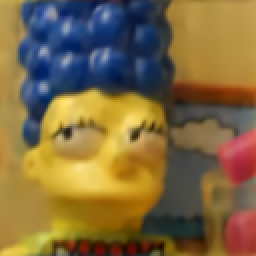

[  20/ 100] [40.48592 s] PSNR = 19.73


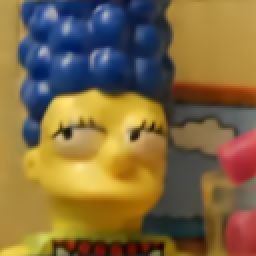

[  30/ 100] [59.39001 s] PSNR = 19.40


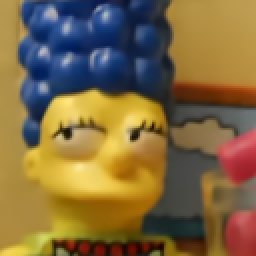

[  40/ 100] [75.69827 s] PSNR = 19.24


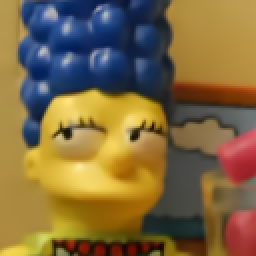

[  50/ 100] [87.79492 s] PSNR = 19.15


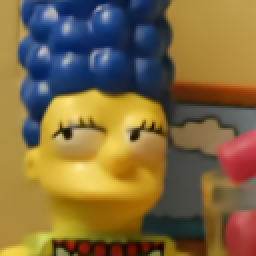

[  60/ 100] [102.79158 s] PSNR = 19.10


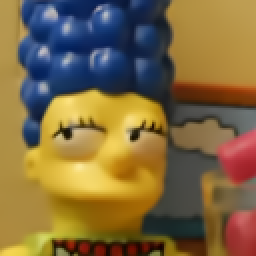

[  70/ 100] [116.06615 s] PSNR = 19.06


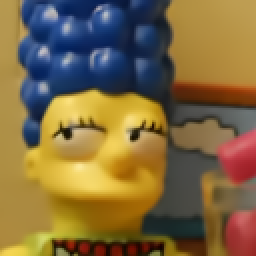

[  80/ 100] [128.13095 s] PSNR = 19.03


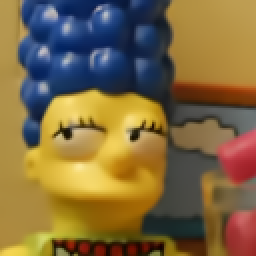

[  90/ 100] [140.68262 s] PSNR = 19.01


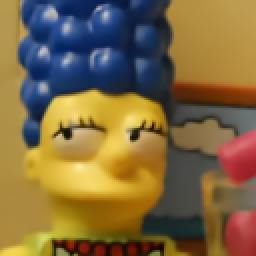

[ 100/ 100] [152.91621 s] PSNR = 18.99


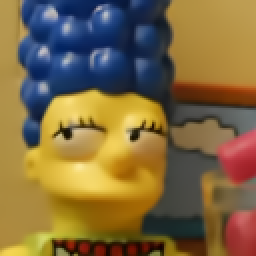

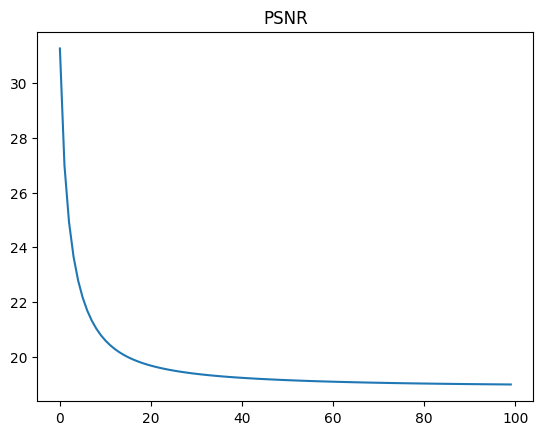

In [ ]:
tau = 2*nu**2###
s = 2*nu  # strength of the denoiser

# initialize with blurry image
x = y.clone()
fk_conj = np.conjugate(fk) #take the conjugate of fk
psnrtab = []  # to store psnr
rtab = []     # to store residual
vtab = []     # to store denoiser variations

x0_norm = torch.norm(x0)
niter = 100
t0 = time.time()
print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(0,niter,0,psnr(x0,y)))

for it in range(niter):
    prox_f = proxf(x,tau)
    x_prev = x.clone()
    x = D(prox_f)
    norm_diff = torch.norm(x - x_prev)

    #rtab
    rtab += [norm_diff/x0_norm]

    #psnrtab
    psnrt = psnr(x,y)
    psnrtab += [psnrt]

    #vtab
    vtab += [torch.norm(D(x) - D(x_prev))/norm_diff]
    if (it+1)%10==0:
        print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(it+1,niter,time.time()-t0,psnrt))
        viewimage(x)

xpgd = x   # save for later comparisons

plt.plot(psnrtab)
plt.title('PSNR')
plt.show()

# plt.semilogy(rtab)
# plt.title('Residual Norm')
# plt.show()

# plt.plot(vtab)
# plt.title('Denoiser Variations')
# plt.show()

## Image deblurring with PnP-DRS

Implement the PnP-DRS algorithm
$$ x_{k+1} = \left(\frac{1}{2} \mathsf{Id} + \frac{1}{2} (2 D_\sigma - \mathsf{Id}) \circ (2\mathsf{Prox}_{\tau f}-\mathsf{Id})\right) (x_k) .$$
Recall that the solution of the inverse problem is obtained after one proximal step
$$ y_k = \mathsf{Prox}_{\tau f} (x_k) .$$

[   0/ 100] [0.00000 s] PSNR = 18.65
[  10/ 100] [12.24640 s] PSNR = 20.78


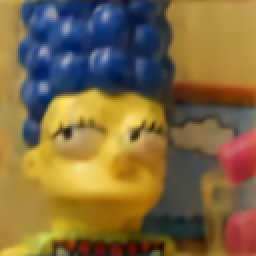

[  20/ 100] [24.38055 s] PSNR = 19.72


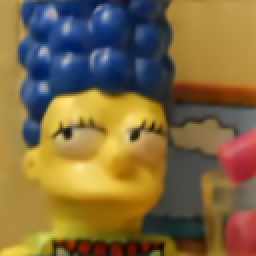

[  30/ 100] [36.38128 s] PSNR = 19.39


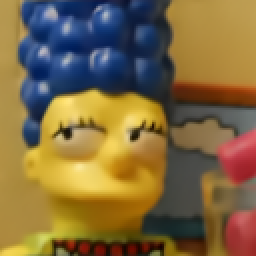

[  40/ 100] [48.40591 s] PSNR = 19.23


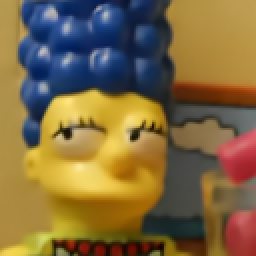

[  50/ 100] [60.44606 s] PSNR = 19.15


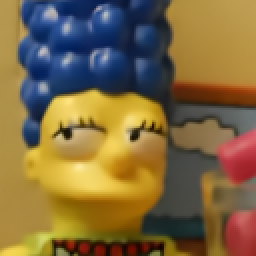

[  60/ 100] [72.55260 s] PSNR = 19.09


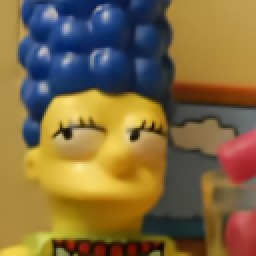

[  70/ 100] [84.59368 s] PSNR = 19.05


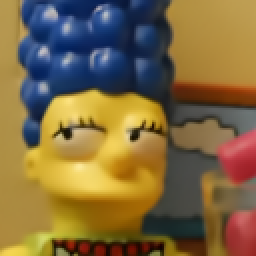

[  80/ 100] [96.83236 s] PSNR = 19.02


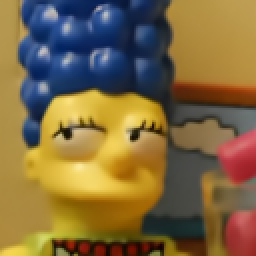

[  90/ 100] [109.00585 s] PSNR = 19.00


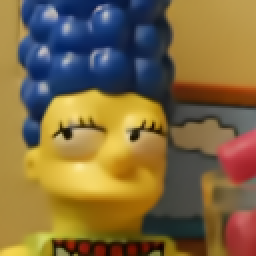

[ 100/ 100] [121.36563 s] PSNR = 18.98


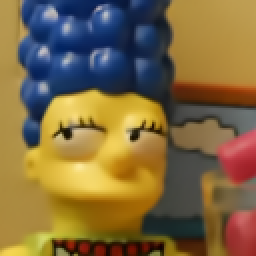

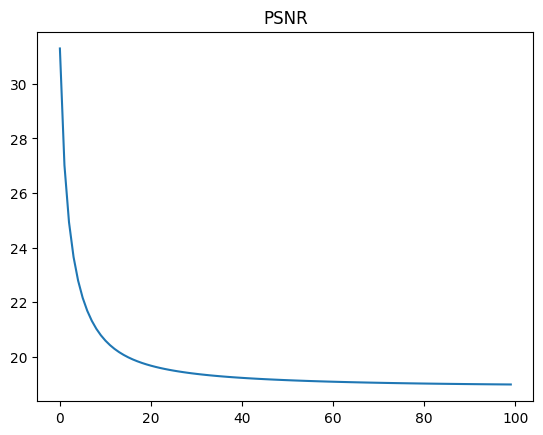

In [ ]:
tau = 2*nu**2###
s = 2*nu  # strength of the denoiser

# initialize with blurry image
x = y.clone()
fk_conj = np.conjugate(fk) #take the conjugate of fk
psnrtab = []  # to store psnr
rtab = []     # to store residual
vtab = []     # to store denoiser variations

x0_norm = torch.norm(x0)
niter = 100
t0 = time.time()
print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(0,niter,0,psnr(x0,y)))

for it in range(niter):
    prox_f = proxf(x,tau)
    x_prev = x.clone()
    x = x/2 + 1/2*(2*D(2*prox_f - x) - 2*prox_f + x)
    norm_diff = torch.norm(x - x_prev)

    #rtab
    rtab += [norm_diff/x0_norm]

    #psnrtab
    psnrt = psnr(x,y)
    psnrtab += [psnrt]

    #vtab
    vtab += [torch.norm(D(x) - D(x_prev))/norm_diff]
    if (it+1)%10==0:
        print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(it+1,niter,time.time()-t0,psnrt))
        viewimage(x)

xpgd = x   # save for later comparisons

plt.plot(psnrtab)
plt.title('PSNR')
plt.show()

# plt.semilogy(rtab)
# plt.title('Residual Norm')
# plt.show()

# plt.plot(vtab)
# plt.title('Denoiser Variations')
# plt.show()

<br/><br/><br/>

# Exercise 2: Image deblurring with non-periodic boundary conditions

Implement a PnP algorithm that addresses image deblurring with non-periodic boundary conditions.

You should adapt the codes written in the previous cells for this new forward model. We advise you to make a copy of the whole notebook and to make the adaptation in a separate file.

Which PnP splitting method can you use for this particular setting?

<br/><br/><br/>

# Exercise 3: Image super-resolution

Implement a PnP algorithm that addresses image deblurring with non-periodic boundary conditions.

You should adapt the codes written in the previous cells for super-resolution. The forward model for super-resolution involves an anti-aliasing filter whose Fourier transform is given in the next cell.

We advise you to make a copy of the whole notebook and to make the adaptation in a separate file.

In [ ]:
# Adjust the framework to address super-resolution with smoothed TV
# For anti-aliasing, you may use the Butterworth filter of order n and cut-off frequency fc
#   given below

# fc is the cut-off frequency normalized in (0,1)
def butterworth(M,N,fc=.5,order=5):
    xi = torch.arange(M)
    ind = (xi>M/2)
    xi[ind] = xi[ind]-M
    zeta = torch.arange(N)
    ind = (zeta>N/2)
    zeta[ind] = zeta[ind]-N
    Xi,Zeta = torch.meshgrid(xi,zeta,indexing='ij')
    Xi = Xi[None,None,:,:].to(device)
    Zeta = Zeta[None,None,:,:].to(device)
    bf1 = 1/torch.sqrt(1+(Xi/(M*fc/2))**(2*order))
    bf2 = 1/torch.sqrt(1+(Zeta/(N*fc/2))**(2*order))
    return bf1*bf2

bf = butterworth(M,N)
viewimage(bf)

# Use example:
bf = butterworth(x0.shape[2],x0.shape[3],fc=.5)
x0f = ifft2(bf*fft2(x0)).real

viewimage(x0)
viewimage(x0f)